
# 📊 Прогнозирование успешности обучения студентов с учетом стратегий обучения

В этом ноутбуке реализована модель классификации (сдал / не сдал), использующая **стратегии обучения студентов** (выделенные на основе кластеризации цифрового следа) в качестве признаков. Цель — показать, что включение этих стратегий улучшает качество модели.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, fbeta_score, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier

from sklearn.preprocessing import Binarizer
from collections import Counter

In [2]:
import sklearn
print(sklearn.__version__)

1.6.1


In [3]:
#!pip install xgboost
#!pip install -U scikit-learn

In [4]:
# fbeta_score(y_true, y_pred, beta=2, average='binary')


## 📥 Подготовка данных

Загружаем и обрабатываем датафрейм `reshaped_df`, содержащий характеристики студентов и их отнесение к стратегиям (кластерам).

# 2 После добавления стратегий

### Пересобрать набор данных

In [7]:
# Загружаем датасет
df = pd.read_excel('data.xlsx')

In [8]:
df.columns

Index(['Column1', 'Группа', 'Идентификатор', 'Код студента', 'Дисциплина',
       'Оценка', 'Форма контроля', 'Е-курс', 'Unnamed: 0', 'Unnamed: 1',
       ...
       'action_21', 'success_21', 'expectation_21', 'Итог', 'sem',
       'biggs_strat_sem1', 'biggs_strat_sem2', 'success_sem1', 'success_sem2',
       'макс действия'],
      dtype='object', length=124)

In [9]:
df=df[df['макс действия'] >= 200]

In [10]:
# Список всех недель, для которых нужно будет распаковать данные
weeks = range(1, 22)  # Недели с 3 по 18

# Список для хранения результатов
reshaped_data = []

In [11]:
# Проходим по каждой строке (студенту) в исходном DataFrame
for index, row in df.iterrows():
    fio = row['ФИО']  # ФИО студента
    course = row ['Дисциплина'] 
    group = row['Группа']
    strat_1 = row['biggs_strat_sem1']
    strat_2 = row['biggs_strat_sem2']
    itog = row['Итог'] # проблемы студента
    #success = row['success_sem2']
    
    # Проходим по каждой неделе
    for week in weeks:
        # Преобразуем данные для текущей недели
        week_prefix = f'week_{week}'
            
        reshaped_data.append({
            'ФИО': fio,
            'Дисциплина': course,
            'Группа': group,
            'Стратегия_1': strat_1,
            'Стратегия_2': strat_2,
            'Номер недели': week,
            'grade': row[f'grade_{week}'],
            'click': row[f'click_{week}'],
            'action': row[f'action_{week}'],
            'success': row[f'success_{week}'],
            'expectation': row[f'expectation_{week}'],
            'Итог': itog
        })

In [12]:
# Создаем новый DataFrame с пересобранными данными
reshaped_df = pd.DataFrame(reshaped_data).dropna()

In [13]:
reshaped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7331 entries, 148 to 14951
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ФИО           7331 non-null   object 
 1   Дисциплина    7331 non-null   object 
 2   Группа        7331 non-null   object 
 3   Стратегия_1   7331 non-null   object 
 4   Стратегия_2   7331 non-null   object 
 5   Номер недели  7331 non-null   int64  
 6   grade         7331 non-null   float64
 7   click         7331 non-null   float64
 8   action        7331 non-null   float64
 9   success       7331 non-null   float64
 10  expectation   7331 non-null   float64
 11  Итог          7331 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 744.6+ KB


### Обучить модель предсказания успешности обучения на основе созданного датасета с данными цифрового следа и результатами промежуточной аттестации.

In [15]:
# Инициализация label encoder для целевой переменной
label_encoder = LabelEncoder()

In [16]:
reshaped_df['itog'] = label_encoder.fit_transform(reshaped_df['Итог'])

In [17]:
# Нормировка признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Z-стандартизация по группе
scaler_z = StandardScaler()
reshaped_df[['z_norm_grade', 'z_norm_click', 'z_norm_action']] = reshaped_df.groupby('Группа')[['grade', 'click', 'action']].transform(lambda x: (x - x.mean()) / x.std())

# Min-Max нормализация по группе
scaler_minmax = MinMaxScaler()
reshaped_df[['minmax_norm_grade', 'minmax_norm_click', 'minmax_norm_action']] = reshaped_df.groupby('Группа')[['grade', 'click', 'action']].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Проверяем данные
print(reshaped_df[['z_norm_grade', 'z_norm_grade', 'minmax_norm_grade']].describe())

       z_norm_grade  z_norm_grade  minmax_norm_grade
count   7331.000000   7331.000000        7331.000000
mean       0.000000      0.000000           0.223752
std        0.999181      0.999181           0.260312
min       -1.952985     -1.952985           0.000000
25%       -0.665531     -0.665531           0.029586
50%       -0.302244     -0.302244           0.141258
75%        0.476258      0.476258           0.295858
max        4.857515      4.857515           1.000000


In [18]:
# Группировка по группам для расчета среднего
reshaped_df['group_mean_grade'] = reshaped_df.groupby('Группа')['grade'].transform('mean')
reshaped_df['group_mean_click'] = reshaped_df.groupby('Группа')['click'].transform('mean')
reshaped_df['group_mean_action'] = reshaped_df.groupby('Группа')['action'].transform('mean')

# Нормировка по группе
reshaped_df['norm_grade'] = reshaped_df['grade'] / reshaped_df['group_mean_grade']
reshaped_df['norm_click'] = reshaped_df['click'] / reshaped_df['group_mean_click']
reshaped_df['norm_action'] = reshaped_df['action'] / reshaped_df['group_mean_action']


## ⚙️ Нормализация признаков

Применяем Z-нормализацию и Min-Max нормализацию по группам, чтобы привести числовые признаки к сопоставимому масштабу.

In [19]:
reshaped_df = reshaped_df.fillna(0)

In [20]:
reshaped_df['itog'].value_counts(normalize=True)

itog
0    0.849407
1    0.150593
Name: proportion, dtype: float64

In [21]:
from sklearn.preprocessing import OneHotEncoder

# Кодирование категориальных переменных
encoder = OneHotEncoder()
reshaped_encoded = encoder.fit_transform(reshaped_df[['Стратегия_1', 'Стратегия_2']]).toarray()
reshaped_encoded_df = pd.DataFrame(reshaped_encoded, columns=encoder.get_feature_names_out())

# Добавляем закодированные переменные и удаляем исходные
reshaped_encoded = pd.concat([reshaped_encoded_df, reshaped_df.reset_index()], axis=1).drop('index', axis=1)

In [22]:
strats = list(encoder.get_feature_names_out())
strats

['Стратегия_1_активизирующиеся к сессии',
 'Стратегия_1_неактивные',
 'Стратегия_1_стабильно активные',
 'Стратегия_1_устающие к сессии',
 'Стратегия_2_активизирующиеся к сессии',
 'Стратегия_2_неактивные',
 'Стратегия_2_стабильно активные',
 'Стратегия_2_устающие к сессии']

In [23]:
reshaped_df = reshaped_encoded[['ФИО', 'itog', 'Номер недели', 'minmax_norm_grade', 'minmax_norm_click', 'minmax_norm_action']+strats]


## 🤖 Обучение моделей

Обучаем несколько классификаторов (логистическая регрессия, случайный лес, XGBoost и др.), используя стратегии как признаки. Также применяем oversampling (SMOTE) и кросс-валидацию.


In [24]:
# Определение моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=500),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [25]:
# Гиперпараметры
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1'], 'solver': ['liblinear']},
    'Decision Tree': {'max_depth': [3, 5, 10, 15, 20], 'criterion': ['gini', 'entropy'],
                      'min_samples_split': [2, 5, 10],  'min_samples_leaf': [1, 2, 4]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 
                      'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']},
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    'Naive Bayes': {'var_smoothing': np.logspace(-9, -3, 7)},
    'Neural Network': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'],
                       'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.01], 'early_stopping': [True]},
    'XGBoost': {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7],
                'subsample': [0.7, 0.8, 1.0], 'colsample_bytree': [0.7, 0.8, 1.0], 'reg_alpha': [0, 0.1, 0.5], 
                'reg_lambda': [0.5, 1.0, 2.0], 'gamma': [0, 0.1, 0.3]}}

In [26]:
# Разные уровни SMOTE
smote_strategies = [0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
thresholds = np.arange(0.3, 0.71, 0.1)

In [27]:
N_SPLITS = 5
final_predictions = []
all_y_tests = []
all_weeks = []

In [28]:
# Define outer cross-validation (for model evaluation)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define inner cross-validation (for hyperparameter tuning)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [29]:
X_full = reshaped_df[['Номер недели', 'minmax_norm_grade', 'minmax_norm_click', 'minmax_norm_action']+strats]
y_full = reshaped_df['itog']
feature_names = X_full.columns.tolist()

# Хранилище результатов
nested_results = []

In [30]:
best_models = {}
best_scores = {}
model_best_per_algo = {}
metrics_by_week = {
    'model': [], 'type': [], 'week': [],
    'accuracy': [], 'recall': [], 'precision': [], 'f1': []
}

In [31]:
# Создаём метрику F2 (recall в 2 раза важнее, чем precision)
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [32]:
for strategy in smote_strategies:
    print(f"\n🔄 Балансировка: SMOTE_{strategy}")
    
    for model_name, model in models.items():
        print(f"\n📌 Модель: {model_name}")
        fold_results = []
        
        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_full, y_full), start=1):
            X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
            y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

            # SMOTE на тренировочной выборке
            sampler = SMOTE(sampling_strategy=strategy, random_state=42)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

            # Поиск гиперпараметров на внутреннем цикле
            grid = GridSearchCV(model, param_grid[model_name], cv=inner_cv, scoring=fbeta_scorer, n_jobs=-1)
            grid.fit(X_resampled, y_resampled)

            best_model = grid.best_estimator_

            # Отбор признаков
            if hasattr(best_model, 'feature_importances_'):
                importances = best_model.feature_importances_
                selected = [col for col, imp in zip(X_full.columns, importances) if imp > 0.01]
            else:
                selected = X_full.columns.tolist()

            X_train_sel = X_resampled[selected]
            X_test_sel = X_test[selected]

            # Переобучение модели на отобранных признаках
            final_model = type(best_model)(**best_model.get_params())
            final_model.fit(X_train_sel, y_resampled)

            # Подбор порога
            best_f1 = 0
            best_thresh = 0.5
            probs = final_model.predict_proba(X_train_sel)[:, 1]
            for threshold in thresholds:
                preds = (probs >= threshold).astype(int)
                score = fbeta_score(y_resampled, preds, zero_division=0, beta=2, average='weighted')
                if score > best_f1:
                    best_f1 = score
                    best_thresh = threshold

            # Оценка на тесте
            test_probs = final_model.predict_proba(X_test_sel)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            test_f1 = fbeta_score(y_test, test_preds, zero_division=0, beta=2, average='weighted')

            fold_results.append({
                'fold': fold,
                'model_name': model_name,
                'model': final_model,
                'balance': strategy,
                'f1': test_f1,
                'threshold': best_thresh,
                'params': grid.best_params_,
                'selected_features': selected
            })

            print(f"Fold {fold} | F1: {test_f1:.4f} | Threshold: {best_thresh} | Features: {len(selected)}")

        # Сохраняем результаты по модели
        nested_results.extend(fold_results)

# Итоговая таблица
df_nested_results = pd.DataFrame(nested_results)
print("\n📊 Итоговая таблица:")
display(df_nested_results.groupby(['model_name', 'balance'])['f1'].mean().reset_index())


🔄 Балансировка: SMOTE_0.375

📌 Модель: Logistic Regression
Fold 1 | F1: 0.8199 | Threshold: 0.4 | Features: 12
Fold 2 | F1: 0.8545 | Threshold: 0.5 | Features: 12
Fold 3 | F1: 0.8190 | Threshold: 0.4 | Features: 12
Fold 4 | F1: 0.8457 | Threshold: 0.5 | Features: 12
Fold 5 | F1: 0.8074 | Threshold: 0.4 | Features: 12

📌 Модель: Decision Tree
Fold 1 | F1: 0.8796 | Threshold: 0.5 | Features: 10
Fold 2 | F1: 0.8848 | Threshold: 0.5 | Features: 8
Fold 3 | F1: 0.8966 | Threshold: 0.5 | Features: 10
Fold 4 | F1: 0.8853 | Threshold: 0.5 | Features: 8
Fold 5 | F1: 0.8945 | Threshold: 0.5 | Features: 10

📌 Модель: Random Forest
Fold 1 | F1: 0.9004 | Threshold: 0.5 | Features: 8
Fold 2 | F1: 0.9064 | Threshold: 0.5 | Features: 8
Fold 3 | F1: 0.9077 | Threshold: 0.4 | Features: 10
Fold 4 | F1: 0.8948 | Threshold: 0.4 | Features: 8
Fold 5 | F1: 0.9026 | Threshold: 0.5 | Features: 8

📌 Модель: KNN
Fold 1 | F1: 0.8397 | Threshold: 0.4 | Features: 12
Fold 2 | F1: 0.8373 | Threshold: 0.4 | Features: 

,model_name,balance,f1
0,Decision Tree,0.375,0.888170
1,Decision Tree,0.500,0.878176
2,Decision Tree,0.625,0.872628
3,Decision Tree,0.750,0.862726
4,Decision Tree,0.875,0.861822
5,Decision Tree,1.000,0.857673
6,KNN,0.375,0.846984
7,KNN,0.500,0.829480
8,KNN,0.625,0.826451
9,KNN,0.750,0.818125


In [33]:
train_names, test_names = train_test_split(reshaped_df['ФИО'].unique(), test_size=0.3, random_state=42)

In [34]:
X_train = reshaped_df[reshaped_df['ФИО'].isin(train_names)][['Номер недели', 'minmax_norm_grade', 
                                                             'minmax_norm_click', 'minmax_norm_action']+strats]
y_train = reshaped_df[reshaped_df['ФИО'].isin(train_names)]['itog']
X_test = reshaped_df[reshaped_df['ФИО'].isin(test_names)][['Номер недели', 'minmax_norm_grade', 
                                                           'minmax_norm_click', 'minmax_norm_action']+strats]
y_test = reshaped_df[reshaped_df['ФИО'].isin(test_names)]['itog']

In [35]:
train_indx = X_train.index
test_indx = X_test.index

In [36]:
# 1. Сохранение лучших моделей:
from sklearn.base import clone

best_models = {}
best_scores = {}

# Группируем только по имени модели
grouped = pd.DataFrame(nested_results).groupby('model_name')

for model_name, group in grouped:
    # Находим строку с наибольшим f1 среди всех настроек и балансов
    top_row = group.loc[group['f1'].idxmax()]
    avg_f1 = top_row['f1']

    balance = top_row['balance']
    best_params = top_row['params']
    selected_features = top_row['selected_features']
    best_thresh = top_row['threshold']

    # Ключ без учета баланса
    key = f"Best_{model_name}"

    # Повторное обучение
    model = models[model_name]
    model_retrained = clone(model).set_params(**best_params)

    sampler = SMOTE(sampling_strategy=balance, random_state=42)
    X_resampled, y_resampled = sampler.fit_resample(X_train[selected_features], y_train)

    model_retrained.fit(X_resampled, y_resampled)

    best_models[key] = (model_retrained, selected_features, best_thresh)
    best_scores[key] = avg_f1


In [37]:
best_scores

{'Best_Decision Tree': 0.8966376656454769,
 'Best_KNN': 0.8627164512888675,
 'Best_Logistic Regression': 0.8545435408779043,
 'Best_Naive Bayes': 0.5765076792185643,
 'Best_Neural Network': 0.8824007352122637,
 'Best_Random Forest': 0.9077179079757115,
 'Best_XGBoost': 0.9129839878891912}

In [38]:
import joblib
import os

# Папка для сохранения
os.makedirs("saved_strat_models", exist_ok=True)

for name, (model, features, threshold) in best_models.items():
    joblib.dump({
        'model': model,
        'features': features,
        'threshold': threshold,
        'f1': best_scores[name]
    }, f"saved_strat_models/{name}.pkl")


In [39]:
test_df = reshaped_df.loc[test_indx]


## 📈 Оценка качества

Оцениваем качество моделей по метрикам: **precision**, **recall**, **F2-score**. Сравниваем результат с базовой моделью (без стратегий обучения).


In [40]:
# 2. Метрики по неделям (на всех данных)
metrics_by_week = {
    'model': [], 'type': [], 'week': [],
    'accuracy': [], 'recall': [], 'precision': [], 'f1': []
}

for key, (model, features, threshold) in best_models.items():
    for week in range(1, 19):
        X_week = test_df[test_df['Номер недели'] == week][features]
        y_week = test_df[test_df['Номер недели'] == week]['itog']

        if len(X_week) > 0:
            probs = model.predict_proba(X_week)[:, 1]
            preds = (probs >= threshold).astype(int)

            metrics_by_week['model'].append(key)
            metrics_by_week['type'].append('full')
            metrics_by_week['week'].append(week)
            metrics_by_week['accuracy'].append(accuracy_score(y_week, preds))
            metrics_by_week['recall'].append(recall_score(y_week, preds, average='weighted'))
            metrics_by_week['precision'].append(precision_score(y_week, preds, average='weighted'))
            metrics_by_week['f1'].append(fbeta_score(y_week, preds, beta=2, average='weighted'))



In [41]:
pd.DataFrame(metrics_by_week)

,model,type,week,accuracy,recall,precision,f1
0,Best_Decision Tree,full,1,0.696078,0.696078,0.931240,0.733104
1,Best_Decision Tree,full,2,0.769912,0.769912,0.908770,0.789464
2,Best_Decision Tree,full,3,0.734513,0.734513,0.883067,0.760086
3,Best_Decision Tree,full,4,0.654867,0.654867,0.887721,0.687542
4,Best_Decision Tree,full,5,0.721739,0.721739,0.895217,0.748054
...,...,...,...,...,...,...,...
121,Best_XGBoost,full,14,0.924370,0.924370,0.950330,0.927521
122,Best_XGBoost,full,15,0.949580,0.949580,0.966078,0.951108
123,Best_XGBoost,full,16,0.958678,0.958678,0.967468,0.959450
124,Best_XGBoost,full,17,0.926829,0.926829,0.956655,0.929074


In [42]:
# 3. Топ-3 модели по F1
sorted_models = sorted(best_scores.items(), key=lambda x: x[1], reverse=True)
print("\n🏆 Топ-3 моделей по F1-score (в среднем по фолдам):")
for name, score in sorted_models[:3]:
    print(f"{name}: F1 = {score:.4f}")



🏆 Топ-3 моделей по F1-score (в среднем по фолдам):
Best_XGBoost: F1 = 0.9130
Best_Random Forest: F1 = 0.9077
Best_Decision Tree: F1 = 0.8966


In [43]:
# Ансамбль
from sklearn.ensemble import VotingClassifier

ensemble_estimators = [
    (name, model[0]) for name, model in best_models.items()
    if best_scores[name] > 0.9
]

if len(ensemble_estimators) > 1:
    common_features = list(set.intersection(*[set(model[1]) for model in best_models.values()]))

    X_full_final = X_train[common_features]
    y_full = y_train

    voting_clf = VotingClassifier(estimators=ensemble_estimators, voting='soft')
    voting_clf.fit(X_full_final, y_full)

    probs_ens = voting_clf.predict_proba(X_full_final)[:, 1]
    preds_ens = (probs_ens >= 0.5).astype(int)
    final_f1 = fbeta_score(y_full, preds_ens, zero_division=0, beta=2, average='weighted')

    print(f"\n🏁 Итоговый F1-score ансамбля: {final_f1:.4f}")

    # Метрики ансамбля по неделям
    for week in range(1, 19):
        X_week = test_df[test_df['Номер недели'] == week][common_features]
        y_week = test_df[test_df['Номер недели'] == week]['itog']

        if len(X_week) > 0:
            probs = voting_clf.predict_proba(X_week)[:, 1]
            preds = (probs >= 0.5).astype(int)

            metrics_by_week['model'].append('Ensemble')
            metrics_by_week['type'].append('full')
            metrics_by_week['week'].append(week)
            metrics_by_week['accuracy'].append(accuracy_score(y_week, preds))
            metrics_by_week['recall'].append(recall_score(y_week, preds, average='weighted'))
            metrics_by_week['precision'].append(precision_score(y_week, preds, average='weighted'))
            metrics_by_week['f1'].append(fbeta_score(y_week, preds, beta=2, average='weighted'))


🏁 Итоговый F1-score ансамбля: 0.9594


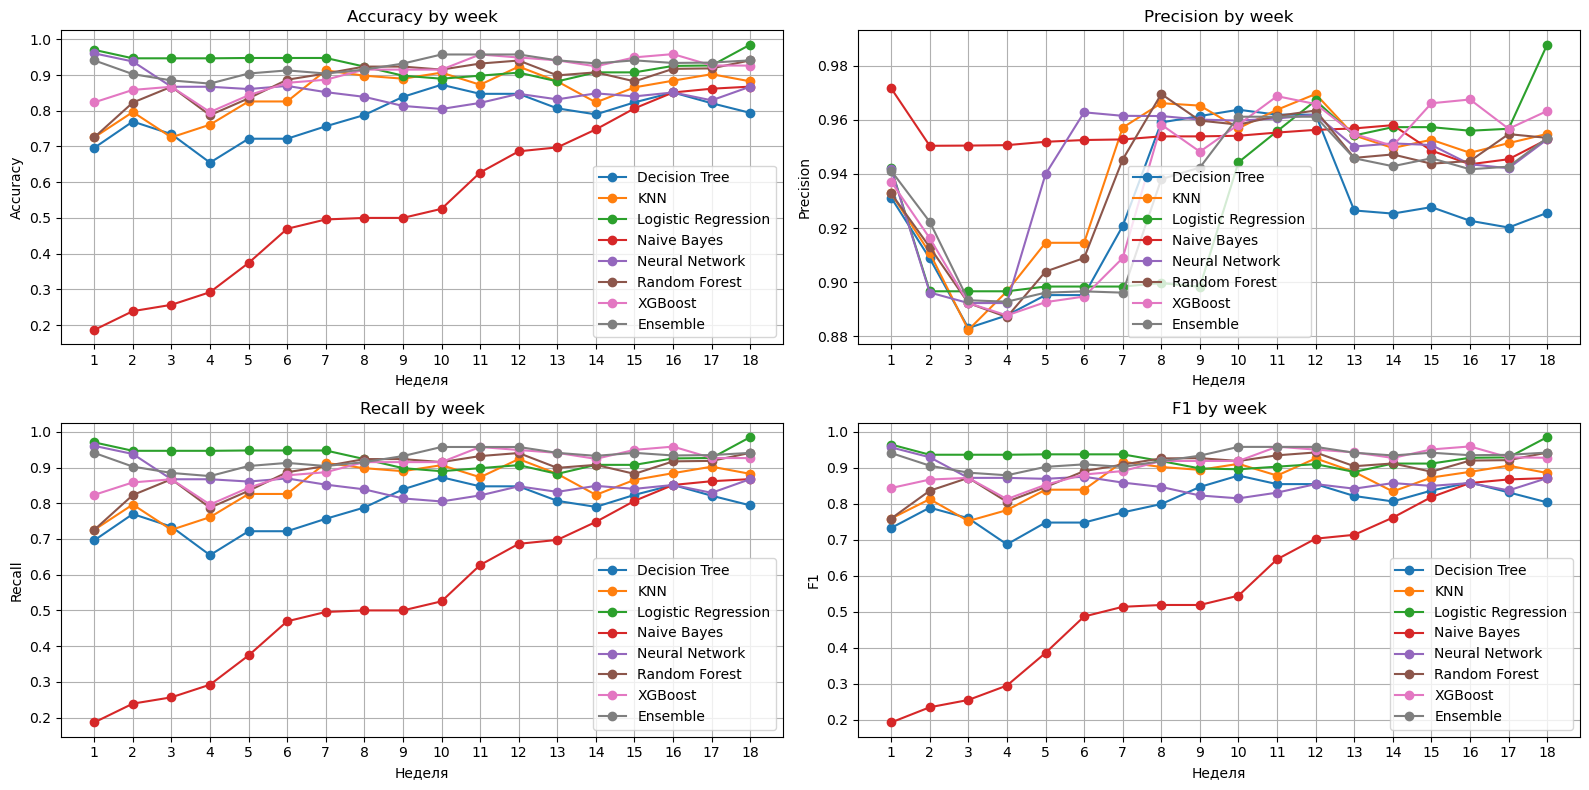

In [44]:
# Построение графиков
metrics_df = pd.DataFrame(metrics_by_week)

plt.figure(figsize=(16, 8))
for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], 1):
    plt.subplot(2, 2, i)
    for model in metrics_df['model'].unique():
        data = metrics_df[(metrics_df['model'] == model) & (metrics_df['type'] == 'full')]
        plt.plot(data['week'], data[metric], label=model.split(sep='_')[-1], marker='o')
    plt.title(f"{metric.capitalize()} by week")
    plt.xticks(range(1, 19))
    plt.xlabel("Неделя")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
